In [1]:
import sys
sys.path.append('src')
import numpy as np
from tqdm import tqdm
from scipy.special import erf, erfinv
from scipy.stats import permutation_test
from matplotlib import colormaps
import matplotlib.pyplot as plt
from models import *
from train_funcs import *
from visualization import *
rng = np.random.default_rng()

In [2]:
# File metadata
TID = 0
AUD_MAP_TYPE = 'neighbor'
HVC_COND = 'mature_hvc'
REC_PLASTICITY = 'EIIE'
postfix = '%s_map_%s_%s_%s' % \
          (AUD_MAP_TYPE, REC_PLASTICITY, HVC_COND, TID)

## Loading

In [3]:
### Constants
NE, NI, N_HVC = 600, 150, 15
PEAK_RATE, KERNEL_WIDTH = 150, 20
dt = 1

In [4]:
netFF, netEI, netEIrecEE, netEIrecEI, aud_mapping = load_models('results/', AUD_MAP_TYPE, 
                                                                REC_PLASTICITY, HVC_COND, TID)

[Text(0, 0.5, 'auditory input neuron'), Text(0.5, 0, 'excitatory neuron')]

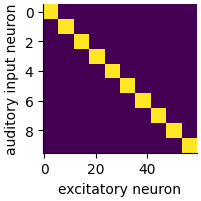

In [5]:
fname = 'realistic_auditory_processing/learned_song_responses.npz'
aud_real, _ = read_realistic_input(fname, NE, mean=0, scale=2, mapping=aud_mapping, mapping_args=None)
fig, ax = plt.subplots(1, figsize=(2,2))
ax.imshow(aud_mapping[:10,:60], interpolation='none', aspect='auto')
ax.set(ylabel='auditory input neuron', xlabel='excitatory neuron')

In [6]:
### Time window of perturbation
PERT_T0 = int(np.round(aud_real['pert_t0'].min(), -1))
PERT_T1 = int(np.round(aud_real['pert_t1'].max(), -1)) + 100

### Constants related to time
T_post = 200 # Silence after song
T_song = aud_real['ctrl'].shape[2]
T_rend = T_song + T_post # Each rendition
T_burn = 500 # Burning

## Testing

In [7]:
N_test_rend = 20
T_test = T_burn+T_rend
_ = np.arange(N_test_rend)
burst_ts = np.linspace(_*T_rend+T_burn, _*T_rend+T_burn+T_song, num=N_HVC, endpoint=False)
_ = rng.standard_normal((N_HVC, N_test_rend)) # Little fluctuation
rH = generate_HVC(T_test, burst_ts, PEAK_RATE+_*0.1, KERNEL_WIDTH+_*0.01)
T_pre = 100 # time period to keep before song
args = (N_test_rend, T_burn, T_post, None, False)
aud_ctrl, aud_ctrl_idx = generate_realistic_aud(aud_real['ctrl'], *args)
aud_pert_weak, aud_pert_idx = generate_realistic_aud(aud_real['pert_weak'], *args)
aud_pert_strong, _ = generate_realistic_aud(aud_real['pert_strong'], *args)
cases = ('ctrl', 'pert_weak', 'pert_strong', 'deaf', 'playback')

In [8]:
hE0 = rng.normal(loc=-10, scale=0.5, size=NE)
hI0 = rng.normal(loc=-1, scale=0.5, size=NI)
# 3 lists for 3 models
res = {k: [np.zeros((N_test_rend,T_pre+T_rend,NE+i)) for i in (0,NI,NI,NI)] for k in cases} 
for k, a in zip(cases, (aud_ctrl, aud_pert_weak, aud_pert_strong, aud_ctrl*0, aud_ctrl)):
    for i in tqdm(range(a.shape[0])): # for each case, enumerate over songs
        rH_ = rH[:T_test] if k != 'playback' else rH[:T_test]*0
        args = dict(rH=rH_, aud=a[i], save_W_ts=[], T=T_test, dt=dt, 
                    noise_strength=1, no_progress_bar=True)
        res[k][0][i] = np.hstack(netFF.sim(hE0, **args)[:1])[T_burn-T_pre:]
        res[k][1][i] = np.hstack(netEI.sim(hE0, hI0, **args)[:2])[T_burn-T_pre:]
        res[k][2][i] = np.hstack(netEIrecEE.sim(hE0, hI0, **args)[:2])[T_burn-T_pre:]
        res[k][3][i] = np.hstack(netEIrecEI.sim(hE0, hI0, **args)[:2])[T_burn-T_pre:]

100%|███████████████████████████████████████████| 20/20 [00:24<00:00,  1.23s/it]


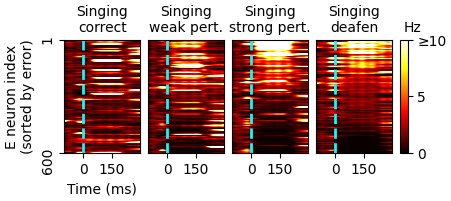

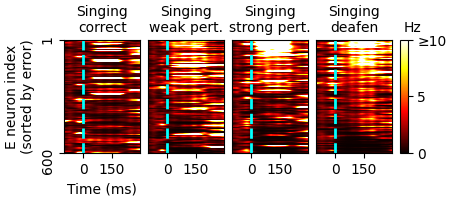

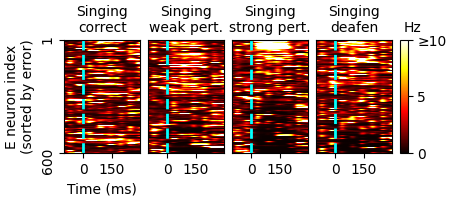

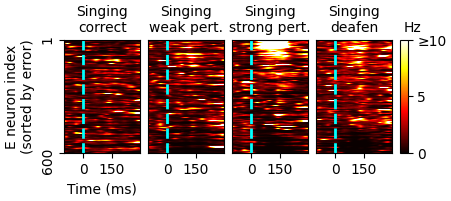

In [9]:
i = 5
titles = ['Singing\ncorrect', 'Singing\nweak pert.', 'Singing\nstrong pert.', 'Singing\ndeafen']
syl = aud_real['ctrl'][:,:,PERT_T0:PERT_T1].mean(axis=(0,2))
for l, m in enumerate(('FF', 'EI', 'EIrecEE', 'EIrecEI')):
    _ = [res[k][l][i,:,:NE] for k in ('ctrl', 'pert_weak', 'pert_strong', 'deaf')]
    t0, t1 = int(aud_real['pert_t0'][i]) + T_pre, int(aud_real['pert_t1'][i]) + T_pre
    bos_ctrl = aud_real['ctrl'][i,:,t0:t1].mean(axis=1)
    bos_weak_pert = aud_real['pert_weak'][i,:,t0:t1].mean(axis=1)
    bos_strong_pert = aud_real['pert_strong'][i,:,t0:t1].mean(axis=1)
    err = [bos_ctrl - syl, bos_weak_pert - syl, bos_strong_pert - syl, -syl]
    fig, ax = plot_raster_cmp_syl_dsyl(_, titles, syl, err, t0, t1+250,
                                       figsize=(4.5, 2), plot_z=False, sort_by='e', th=10, tpre=100) 
    for j in range(len(ax)-1):
        ax[j].set(xticks=[100, 250], xticklabels=[0, 150], xlabel='')
    ax[0].set(xlabel='Time (ms)')
    fig.savefig('svg/different_models/err_response_%s_%s.svg' % (m, postfix), transparent=True)

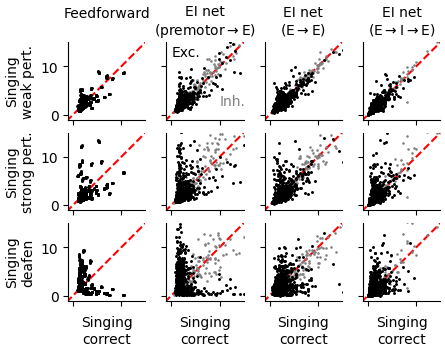

In [10]:
fig, ax = plt.subplots(3, 4, figsize=(4.5, 3.5), sharex='all', sharey='all')
# t0, t1 = T_pre + PERT_T0, T_pre + PERT_T1
t0, t1 = T_pre, T_pre + T_song
for i in range(4): 
    z_ctrl = res['ctrl'][i][:,t0:t1].mean(axis=(0,1))
    for j, k in enumerate(('pert_weak', 'pert_strong', 'deaf')):
        z_pert = res[k][i][:,t0:t1].mean(axis=(0,1))
        ax[j,i].scatter(z_ctrl[NE:], z_pert[NE:], s=3, c='grey', zorder=-2)
        ax[j,i].scatter(z_ctrl[:NE], z_pert[:NE], s=5, c='k', zorder=-1)
        # ax[j,i].hist2d(z_ctrl[:NE], z_pert[:NE], bins=20, norm='log', 
        #                cmap='binary', range=((0,20),(0,20)));
        ax[j,i].plot([-3, 50], [-3,50], c='r', ls='--', zorder=-3)
        ax[j,i].set_rasterization_zorder(0)
        ax[-1,i].set(xlabel='Singing\ncorrect')
        if i < 2:
            ax[j,i].set(aspect=1, ylim=[-2,15], xlim=[-2,15], 
                        yticks=[0,10], xticks=[0,10])
        elif i == 2:
            ax[j,i].set(aspect=1, ylim=[-1,15], xlim=[-1,15], 
                        yticks=[0,10], xticks=[0,10])
        elif i == 3:
            ax[j,i].set(aspect=1, ylim=[-1,15], xlim=[-1,15], 
                        yticks=[0,10], xticks=[0,10])
        if j != 2:
            ax[j,i].set_xticklabels(['', ''])
        # if i not in (0, 2):
        #     ax[j,i].set_yticklabels(['', ''])
        
ax[0,1].text(0, 12, 'Exc.', c='k', zorder=1)
ax[0,1].text(10, 2, 'Inh.', c='grey', zorder=1)
ax[0,0].set_ylabel('Singing\nweak pert.')
ax[1,0].set_ylabel('Singing\nstrong pert.')
ax[2,0].set_ylabel('Singing\ndeafen')
ax[0,0].set_title('Feedforward\n', fontsize=10)
ax[0,1].set_title('EI net\n(premotor$\\to$E)', fontsize=10)
ax[0,2].set_title('EI net\n(E$\\to$E)', fontsize=10)
ax[0,3].set_title('EI net\n(E$\\to$I$\\to$E)', fontsize=10)
fig.savefig('svg/different_models/learn_real_joint_dist_%s.svg' % postfix, dpi=200)

0.06523372319376035
0.002335427795475477
0.9999511508371685
0.0033141817509398305


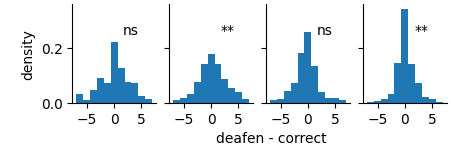

In [11]:
from scipy.stats import wilcoxon
fig, ax = plt.subplots(1, 4, figsize=(4.5, 1.5), sharex='all', sharey='all')
ls = ['Feedforward\n', 'EI net\n(premotor$\\to$E)', 
      'EI net\n(E$\\to$E)', 'EI net\n(E$\\to$I$\\to$E)']
# t0, t1 = T_pre + PERT_T0, T_pre + PERT_T1
t0, t1 = T_pre, T_pre + T_song
for i, l in enumerate(ls): 
    z_ctrl = res['ctrl'][i][:,t0:t1].mean(axis=(0,1))
    z_pert = res['deaf'][i][:,t0:t1].mean(axis=(0,1))
    diff = z_pert[:NE] - z_ctrl[:NE]
    pval = wilcoxon(diff, alternative='greater').pvalue
    print(pval)
    ax[i].hist(diff, bins=11, range=(-7, 7), density=True)
    ax[i].text(3, 0.25, 'ns' if pval > 0.05 else ('*' if pval > 0.01 else '**'), ha='center')
    # ax[i].plot([1,2], [z_ctrl, z_pert], c='k', alpha=0.1)
    # ax[i].boxplot([z_ctrl, z_pert])
    # ax[i].hist([z_ctrl[:NE], z_pert[:NE]], bins=11, histtype='stepfilled', alpha=0.8)
    ax[i].set(xlabel=' ')
ax[0].set(ylabel='\ndensity')
fig.text(0.6, 0.05, 'deafen - correct', ha='center')
fig.savefig('svg/deaf_diff_models.svg')

[[np.float64(0.0001), np.float64(0.0001)], [np.float64(0.0001), np.float64(0.0001)], [np.float64(0.0023), np.float64(1.0)], [np.float64(0.0001), np.float64(0.0001)]]


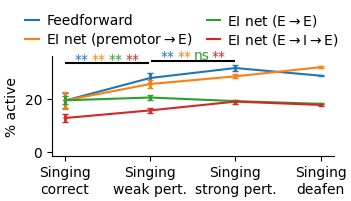

In [12]:
titles = ['Singing\ncorrect', 'Singing\nweak pert.', 'Singing\nstrong pert.', 'Singing\ndeafen']
fig, ax = plt.subplots(1, figsize=(3.5, 2))
def statistic(x, y):
    return x.mean() - y.mean()
ls = ['Feedforward', r'EI net (premotor$\to$E)', 
      r'EI net (E$\to$E)', r'EI net (E$\to$I$\to$E)']
pvs = []
for i, (m, l) in enumerate(zip(('FF', 'EI', 'EIrecEE', 'EIrecEI'), ls)):
    color = 'C%d' % i
    t0, t1 = PERT_T0+T_pre, PERT_T1+T_pre
    # data = [(res[k][i][:,t0:t1,:NE].mean(axis=1)>5).mean(axis=-1)*100
    #         for k in ('ctrl', 'pert_weak', 'pert_strong', 'deaf')]
    data = [(res[k][i][:,t0:t1,:NE]>3).mean(axis=(1,2))*100
            for k in ('ctrl', 'pert_weak', 'pert_strong', 'deaf')]
    data = np.stack(data)
    ax.errorbar([0,1,2,3], data.mean(axis=1), yerr=data.std(axis=1), 
                capsize=2, elinewidth=2, c=color)
    ax.plot(0, 0, c=color, label=l)
    pvs.append([permutation_test(data[0:2], statistic, alternative='less').pvalue, 
                permutation_test(data[1:3], statistic, alternative='less').pvalue])
print(pvs)
y = ax.get_ylim()[1]-1
ax.hlines([y, y+1], [0.01, 1.01], [0.99, 1.99], color='k')
for i in range(4): # 3 models
    for j, pv in enumerate(pvs[i]):
        if pv < 0.05:
            ax.text(j+0.5+(i-1.5)*0.2, y+j, 
                    '*' if pv > 0.01 else '**', ha='center', c='C%d'%i)
        else:
            ax.text(j+0.5+(i-1.5)*0.2, y+0.5+j, 'ns', ha='center', c='C%d'%i)
ax.set(xticks=[0,1,2,3], xticklabels=titles, ylabel='% active', title='\n$\ $\n')
fig.legend(ncols=2)
fig.savefig('svg/different_models/percent_active_%s.svg' % postfix)

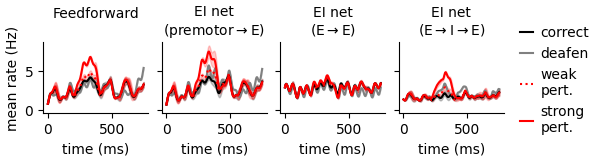

In [13]:
fig, ax = plt.subplots(1, 5, figsize=(6,1.6), sharey='all', width_ratios=(1,1,1,1,0.8))
ls = ['Feedforward\n', 'EI net\n(premotor$\\to$E)', 
      'EI net\n(E$\\to$E)', 'EI net\n(E$\\to$I$\\to$E)']
for i, k in enumerate(ls):
    for j, c in zip(('deaf', 'ctrl', 'pert_weak', 'pert_strong'), ('grey', 'k', 'r', 'r')):
        aux = res[j][i][:,T_pre:-T_post-50,:NE].mean(axis=-1)
        plot_mean_std(ax[i], aux.mean(axis=0), aux.std(axis=0), 0.2, c, 
                      ls=':' if j=='pert_weak' else '-')
        # ax[i].hlines(7, aud_real['pert_t0'].mean()-aud_real['pert_t0'].std(), 
        #                 aud_real['pert_t1'].mean()+aud_real['pert_t1'].std(),
        #              lw=3, color='m')
    ax[i].set(xlabel='time (ms)', title=k)
ax[-1].set_axis_off()
ax[0].set_ylabel('mean rate (Hz)')
for k, c in zip(('correct', 'deafen', 'weak\npert.', 'strong\npert.'), ('k', 'grey', 'r', 'r')):
    ax[0].plot(0,0, c=c, ls=':' if k=='weak\npert.' else '-', 
               label=k)
fig.legend(ncols=1, loc='center right', labelspacing=0.5)
fig.savefig('svg/different_models/learn_real_mean_rates_%s.svg' % postfix)

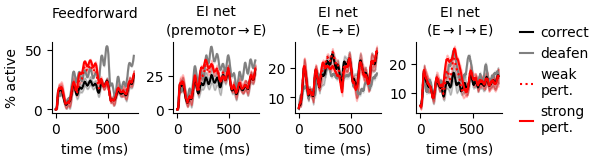

In [14]:
fig, ax = plt.subplots(1, 5, figsize=(6,1.6), sharey='none', width_ratios=(1,1,1,1,1))
ls = ['Feedforward\n', 'EI net\n(premotor$\\to$E)', 
      'EI net\n(E$\\to$E)', 'EI net\n(E$\\to$I$\\to$E)']
for i, k in enumerate(ls):
    for j, c in zip(('deaf', 'ctrl', 'pert_weak', 'pert_strong'), ('grey', 'k', 'r', 'r')):
        aux = (res[j][i][:,T_pre:-T_post-50,:NE] > 3).mean(axis=-1) * 100
        plot_mean_std(ax[i], aux.mean(axis=0), aux.std(axis=0), 0.2, c, 
                      ls=':' if j=='pert_weak' else '-')
        # ax[i].hlines(7, aud_real['pert_t0'].mean()-aud_real['pert_t0'].std(), 
        #                 aud_real['pert_t1'].mean()+aud_real['pert_t1'].std(),
        #              lw=3, color='m')
    ax[i].set(xlabel='time (ms)', title=k)
ax[-1].set_axis_off()
ax[0].set_ylabel('% active')
for k, c in zip(('correct', 'deafen', 'weak\npert.', 'strong\npert.'), ('k', 'grey', 'r', 'r')):
    ax[0].plot(0,0, c=c, ls=':' if k=='weak\npert.' else '-', 
               label=k)
fig.legend(ncols=1, loc='center right', labelspacing=0.5)
fig.savefig('svg/different_models/learn_real_sparsity_%s.svg' % postfix)

600 0
600 0
119 31
600 0
119 31
260 340
40 110


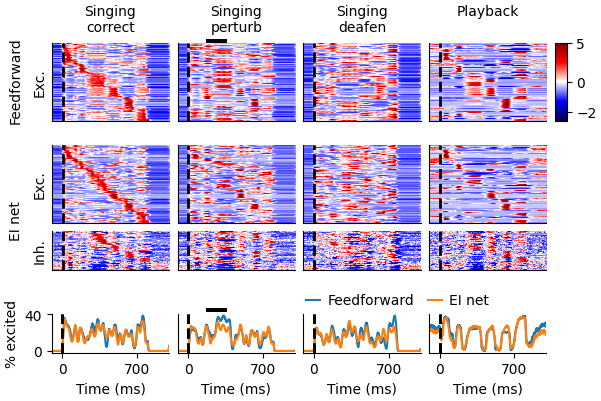

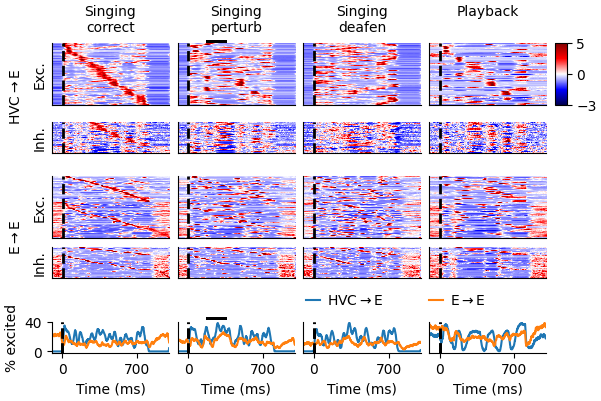

In [15]:
t0 = int(np.round(aud_real['pert_t0'].min(), -1)) + T_pre
t1 = int(np.round(aud_real['pert_t1'].max(), -1)) + T_pre + 100

ks = ('ctrl', 'pert_strong', 'deaf', 'playback')
titles = ['Singing\ncorrect', 'Singing\nperturb', 'Singing\ndeafen', 'Playback\n']
fig, ax = plot_raster([res[k][0][i] for k in ks], [res[k][1][i] for k in ks], 
                      'Feedforward', 'EI net', NE, titles, 
                      0, T_pre+T_rend, T_pre, t0, t1)
# fig.savefig('svg/different_models/compare_EI_FF_%s.svg' % postfix, transparent=True)

fig, ax = plot_raster([res[k][1][i] for k in ks], [res[k][3][i] for k in ks], 
                      r'HVC$\to$E'+' '*8, r'E$\to$E'+' '*8, NE, titles, 
                      0, T_pre+T_rend, T_pre, t0, t1)
fig.savefig('svg/different_models/compare_EI_EIrec_%s.svg' % postfix, transparent=True)